In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch import autograd
from skimage.io import imread
import matplotlib.pyplot as plt

In [2]:
from IPython.display import clear_output

In [3]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [4]:
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, activation_fn=None, use_bn=False):
        super(conv_block, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=kernel_size//2)
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else None
        self.activ = activation_fn
    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.activ is not None:
            x = self.activ(x)
        return x

class Generator(nn.Module):
    def __init__(
        self,
        input_channel,
        z_num=64,
        repeat_num = int(np.log2(256) - 2),
        hidden_num = 128,
        activation_fn=torch.nn.functional.elu,
        min_fea_map_H=8,
        n_channels_pose=3,
        *args, **kwargs
    ):
        super(Generator, self).__init__(*args, **kwargs)
        assert min_fea_map_H * 2 ** (repeat_num - 1) == 128
        self.repeat_num = repeat_num
        self.min_fea_map_H = min_fea_map_H
        self.hidden_num = hidden_num
        
        # Encoder
        self.encoder = nn.ModuleList()
        self.encoder.add_module(
            'conv_0_0', conv_block(input_channel + n_channels_pose, hidden_num, 3, 1, activation_fn)
        )
        
        for idx in range(repeat_num):
            channel_num = hidden_num * (idx + 1)
            self.encoder.add_module(
                'conv_{}_{}'.format(idx + 1, 0), conv_block(channel_num, channel_num, 3, 1, activation_fn)
            )
            self.encoder.add_module(
                'conv_{}_{}'.format(idx + 1, 1), conv_block(channel_num, channel_num, 3, 1, activation_fn)
            )
            if idx < repeat_num - 1:
                self.encoder.add_module(
                    'down_{}'.format(idx + 1), conv_block(channel_num, channel_num + hidden_num, 3, 2, activation_fn)
                )
                
        # Bottleneck
        self.bottleneck = nn.Linear(int(np.prod([min_fea_map_H, min_fea_map_H, channel_num])), z_num)
        
        self.decoder = nn.ModuleList()
        
        self.decoder.add_module('fc0', nn.Linear(z_num, int(np.prod([min_fea_map_H, min_fea_map_H, hidden_num]))))
        
        for idx in range(repeat_num):
            channel_num = hidden_num * (repeat_num + 1) if idx == 0 else 2 * hidden_num*(repeat_num-idx)
            #hidden_num * (repeat_num + 1) if idx < repeat_num - 1 else 2 * hidden_num
            self.decoder.add_module(
                'conv_{}_{}'.format(idx, 0), conv_block(channel_num, channel_num, 3, 1, activation_fn)
            )
            self.decoder.add_module(
                'conv_{}_{}'.format(idx, 1), conv_block(channel_num, channel_num, 3, 1, activation_fn)
            )
            if idx < repeat_num - 1:
                self.decoder.add_module(
                    'up_{}'.format(idx), nn.Upsample(scale_factor=2, mode='nearest')
                )
                self.decoder.add_module(
                    'up_conv_{}'.format(idx), conv_block(channel_num, hidden_num*(repeat_num-idx-1), 1, 1, activation_fn)
                )
                
        self.head = conv_block(2 * hidden_num, input_channel, 3, 1, activation_fn=None)
    
    def forward(self, x):
        self.encoder_list = []
        # Encode
        x = self.encoder.conv_0_0(x)
        for idx in range(self.repeat_num):
            res = x
            x = self.encoder.__getattr__('conv_{}_{}'.format(idx + 1, 0))(x)
            x = self.encoder.__getattr__('conv_{}_{}'.format(idx + 1, 1))(x)
            x = res + x
            self.encoder_list.append(x)
            if idx < self.repeat_num - 1:
                x = self.encoder.__getattr__('down_{}'.format(idx + 1))(x)
        # Bottleneck
        z = x = self.bottleneck(torch.reshape(x, (x.shape[0], -1)))
        # Decode
        x = self.decoder.fc0(x)
        x = torch.reshape(x, (x.shape[0], self.hidden_num, self.min_fea_map_H, self.min_fea_map_H))
        for idx in range(self.repeat_num):
            x = torch.cat([x, self.encoder_list[self.repeat_num-1-idx]], dim=1)
            res = x
            x = self.decoder.__getattr__('conv_{}_{}'.format(idx, 0))(x)
            x = self.decoder.__getattr__('conv_{}_{}'.format(idx, 1))(x)
            x = x + res
            if idx < self.repeat_num - 1:
                x = self.decoder.__getattr__('up_{}'.format(idx))(x)
                x = self.decoder.__getattr__('up_conv_{}'.format(idx))(x)
                
        out = self.head(x)
        return out, z
    
class Refiner(nn.Module):
    def __init__(
        self,
        input_channel,
        repeat_num = int(np.log2(256)) - 2,
        hidden_num = 128,
        activation_fn=torch.nn.functional.elu,
        min_fea_map_H=8,
        noise_dim=0,
        device=torch.device('cpu:0'),
        *args, **kwargs
    ):
        super(Refiner, self).__init__(*args, **kwargs)
        assert min_fea_map_H * 2 ** (repeat_num - 1) == 128
        self.repeat_num = repeat_num
        self.min_fea_map_H = min_fea_map_H
        self.hidden_num = hidden_num
        self.noise_dim = noise_dim
        self.device = device
        
        # Encoder
        self.encoder = nn.ModuleList()
        self.encoder.add_module(
            'conv_0_0', conv_block(2 * input_channel, hidden_num, 3, 1, activation_fn)
        )
        
        for idx in range(repeat_num):
            channel_num = hidden_num * (idx + 1)
            self.encoder.add_module(
                'conv_{}_{}'.format(idx + 1, 0), conv_block(max(channel_num - hidden_num, hidden_num), channel_num, 3, 1, activation_fn)
            )
            self.encoder.add_module(
                'conv_{}_{}'.format(idx + 1, 1), conv_block(channel_num, channel_num, 3, 1, activation_fn)
            )
            if idx < repeat_num - 1:
                self.encoder.add_module(
                    'down_{}'.format(idx + 1), conv_block(channel_num, channel_num, 3, 2, activation_fn)
                )
        self.decoder = nn.ModuleList()
        for idx in range(repeat_num):
            channel_num = 2 * channel_num + noise_dim if idx == 0 else hidden_num + hidden_num * (repeat_num - idx)
            self.decoder.add_module(
                'conv_{}_{}'.format(idx, 0), conv_block(channel_num, hidden_num, 3, 1, activation_fn)
            )
            self.decoder.add_module(
                'conv_{}_{}'.format(idx, 1), conv_block(hidden_num, hidden_num, 3, 1, activation_fn)
            )
            if idx < repeat_num - 1:
                self.decoder.add_module(
                    'up_{}'.format(idx), nn.Upsample(scale_factor=2, mode='nearest')
                )
                
        self.head = conv_block(hidden_num, input_channel, 3, 1, activation_fn=None)
    
    def forward(self, x):
        self.encoder_list = []
        # Encode
        x = self.encoder.conv_0_0(x)
        for idx in range(self.repeat_num):
            x = self.encoder.__getattr__('conv_{}_{}'.format(idx + 1, 0))(x)
            x = self.encoder.__getattr__('conv_{}_{}'.format(idx + 1, 1))(x)
            self.encoder_list.append(x)
            if idx < self.repeat_num - 1:
                x = self.encoder.__getattr__('down_{}'.format(idx + 1))(x)
        
        # Random noise
        if self.noise_dim > 0:
            random = torch.tensor(
                np.random.uniform(-1, 1, size=(x.shape[0], self.noise_dim, self.min_fea_map_H, self.min_fea_map_H)),
                dtype=torch.float32,
                device=self.device
            )
            x = torch.cat([x, random], dim=1)
        
        # Decode
        for idx in range(self.repeat_num):
            x = torch.cat([x, self.encoder_list[self.repeat_num-1-idx]], dim=1)
            x = self.decoder.__getattr__('conv_{}_{}'.format(idx, 0))(x)
            x = self.decoder.__getattr__('conv_{}_{}'.format(idx, 1))(x)
            if idx < self.repeat_num - 1:
                x = self.decoder.__getattr__('up_{}'.format(idx))(x)
                
        out = self.head(x)
        return out

In [5]:
def init_uniform(layer, stdev=0.02):
    layer.load_state_dict(
        {'weight' : torch.tensor(
            np.random.uniform(-stdev * np.sqrt(3), +stdev * np.sqrt(3), layer.state_dict()['weight'].shape),
            dtype=torch.float32
        ), 
         'bias' : torch.tensor(np.zeros(layer.state_dict()['bias'].shape), dtype=torch.float32)
        }
    )

class DCGANDiscriminator(nn.Module):
    
    def __init__(self, input_dim=3, dim=64, activation=nn.functional.leaky_relu, use_bn=True, *args, **kwargs):
        
        super(DCGANDiscriminator, self).__init__(*args, **kwargs)
        self.dim = dim
        
        self.conv_0 = conv_block(input_dim, dim, 5, 2, activation)
        init_uniform(self.conv_0.conv)

        self.conv_1 = conv_block(dim, 2 * dim, 5, 2, activation, use_bn=use_bn)
        init_uniform(self.conv_1.conv)

        self.conv_2 = conv_block(2*dim, 4*dim, 5, 2, activation, use_bn=use_bn)
        init_uniform(self.conv_2.conv)

        self.conv_3 = conv_block(4*dim, 8*dim, 5, 2, activation, use_bn=use_bn)
        init_uniform(self.conv_3.conv)

        self.conv_4 = conv_block(8*dim, 8*dim, 5, 2, activation, use_bn=use_bn)
        init_uniform(self.conv_4.conv)

        self.head = nn.Linear(8*8*8*dim, 1)
        init_uniform(self.head)
    
    def forward(self, x):
        x = self.conv_0(x)
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = torch.reshape(x, (x.shape[0], 8*8*8*self.dim))
        out = self.head(x)
        return out
    
def gan_loss(disc_real, disc_fake):
        gen_cost = torch.mean(torch.nn.functional.binary_cross_entropy_with_logits(
            disc_fake,
            torch.ones_like(disc_fake, dtype=torch.float32)
        ))
        disc_cost =  0.5 * torch.mean(torch.nn.functional.binary_cross_entropy_with_logits(
            disc_fake,
            torch.zeros_like(disc_fake, dtype=torch.float32)
        )) + 0.5 * torch.mean(torch.nn.functional.binary_cross_entropy_with_logits(
            disc_real,
            torch.ones_like(disc_real, dtype=torch.float32)
        ))
        return gen_cost, disc_cost
    
def compute_loss_2(source_true, target_true, target_g2, discriminator, LAMBDA):
    inp_true = torch.cat([target_true, source_true], dim=0) # true im
    inp_fake = torch.cat([target_g2, source_true], dim=0) # fake pair
    logits_true = discriminator(inp_true)
    logits_fake = discriminator(inp_fake)
    g2_loss_adv, d_loss = wgan_loss(logits_true, logits_fake)
    l1_loss = torch.mean(torch.abs(target_g2 - target_true))
    return g2_loss_adv, l1_loss, d_loss + LAMBDA * calc_gradient_penalty(discriminator, inp_true, inp_fake)

def compute_loss_1(target_true, target_g1):
    g1_loss = torch.mean(torch.abs(target_g1 - target_true))
    return g1_loss

def wgan_loss(disc_real, disc_fake):
    loss = -torch.sum(disc_fake, dim=1).mean(), \
           -(torch.sum(disc_real, dim=1).mean() - torch.sum(disc_fake, dim=1).mean())
    return loss
    
def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand((real_data.shape[0],1, 1, 1))
    alpha = alpha.expand(real_data.shape)
    alpha = alpha.cuda()

    interpolates = alpha * real_data.data + (1.0 - alpha) * fake_data.data

    interpolates = interpolates.cuda()
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda(),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [6]:
device = torch.device('cuda:0') 

In [7]:
generator = Generator(input_channel=3, repeat_num=4, min_fea_map_H=16).cuda()
#dummy_im = torch.tensor(np.zeros((1, 3, 256, 256)), dtype=torch.float32)#, device=device)
#dummy_pose = torch.tensor(np.zeros((1, 3, 256, 256)), dtype=torch.float32)#, device=device)

In [8]:
discriminator = DCGANDiscriminator().cuda()
refiner = Refiner(input_channel=3, noise_dim=0, repeat_num=4, min_fea_map_H=16, device=device).cuda()

In [9]:
#out_1, z = generator(torch.cat([dummy_im, dummy_pose], dim=1))
#out_2 = refiner(torch.cat([dummy_im, out_1], dim=1))
#logit = discriminator(out_2)

In [10]:
from loader_py import get_train_loader
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
loader = get_train_loader('./deepfashion/index.p', batch_size=25, resize_size=128, train=True)

In [12]:
gen_train_op1 = torch.optim.RMSprop(generator.parameters(), lr=0.00002)
disc_train_op = torch.optim.RMSprop(discriminator.parameters(), lr=0.00002)

In [13]:
gen_train_op2 = torch.optim.RMSprop(refiner.parameters(), lr=0.00002)

In [14]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

In [20]:
start_step = 5000
losses = {
    'generator' : [],
    'refiner_adv' : [],
    'refiner_l1' : [],
    'critic' : []
}

In [21]:
generator.load_state_dict(torch.load('./generator_128_{}.model'.format(start_step)))

In [22]:
iterator = cycle(loader)
log_step = 100
max_step = 50000
save_step = 2500
stage_one_steps = 22000

In [23]:
losses['refiner'] = []
losses['critic'] = []

step: 5000


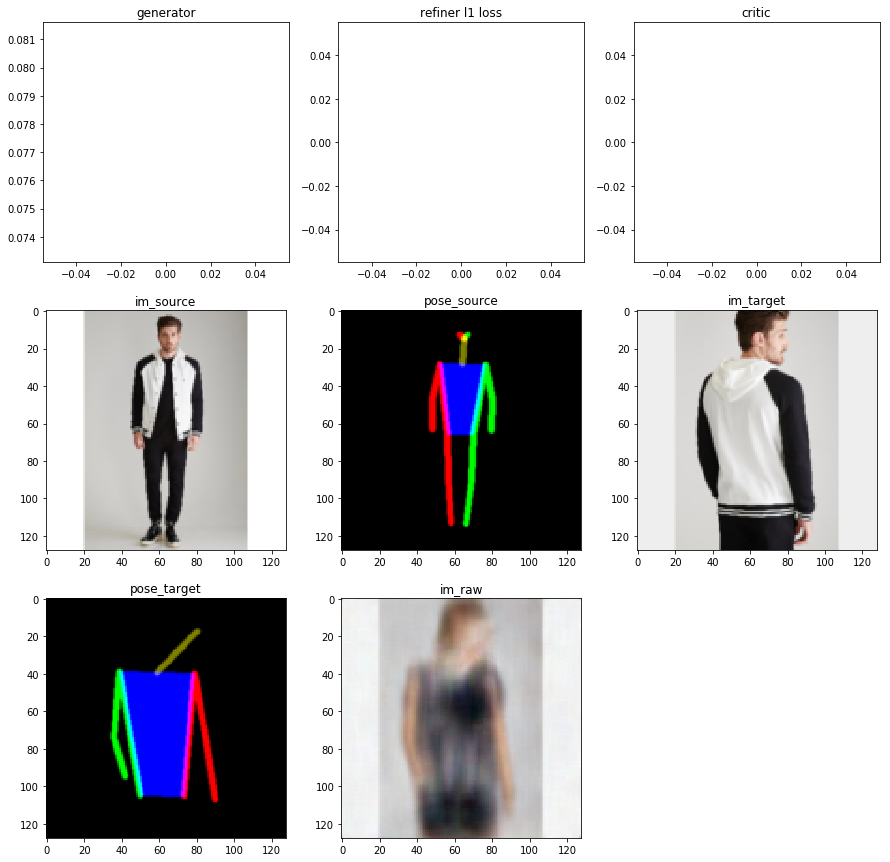

mean loss gen 0.07735148817300797


TypeError: int() argument must be a string, a bytes-like object or a number, not 'JpegImageFile'

In [24]:
clamp_lower, clamp_upper =  [-.01, .01]
lambd = 50.

try:
    for step in range(start_step, max_step):

        images, poses = next(iterator)

        im_source = images[:, 0, :, :, :]
        pose_source = poses[:, 0, :, :, :]

        im_target = images[:, 1, :, :, :]
        pose_target = poses[:, 1, :, :, :]

        if step < stage_one_steps:

            im_raw, _ = generator(torch.cat([im_source, pose_target], dim=1).cuda())

            loss = compute_loss_1(im_target.cuda(), im_raw.cuda())

            gen_train_op1.zero_grad()
            loss.backward()
            gen_train_op1.step()

            losses['generator'].append(loss.detach().cpu().numpy())
        else:
            im_raw, _ = generator(torch.cat([im_source, pose_target], dim=1).cuda())
            diff = refiner(torch.cat([im_raw, im_source.cuda()], dim=1))
            im_refined = im_raw + diff

            loss_gen_adv, loss_gen_l1, loss_discrim = compute_loss_2(
                im_source.cuda(), im_target.cuda(), im_refined, discriminator, LAMBDA=10
            )

            loss_gen = loss_gen_adv + lambd * loss_gen_l1
            
            gen_train_op2.zero_grad()
            loss_gen.backward(retain_graph=True)
            gen_train_op2.step()
            
            disc_train_op.zero_grad()
            loss_discrim.backward(retain_graph=True)
            disc_train_op.step()

            losses['refiner_adv'].append(loss_gen_adv.detach().cpu().numpy())
            losses['refiner_l1'].append(loss_gen_l1.detach().cpu().numpy())
            losses['critic'].append(loss_discrim.detach().cpu().numpy())

        if (step % save_step) == 0:
            if step < stage_one_steps:
                torch.save(generator.state_dict(), '/home/spdivkov/dl_project/generator_128_{}.model'.format(step))
            else:
                torch.save(refiner.state_dict(), '/home/spdivkov/dl_project/refiner_128_{}.model'.format(step))
                torch.save(discriminator.state_dict(), '/home/spdivkov/dl_project/critic_128_{}.model'.format(step))
            
        if (step % log_step) == 0:
            clear_output(wait=True)
            
            print('step: {}'.format(step))
            plt.figure(figsize=(15, 15))
            
            if step < stage_one_steps:
                plt.subplot(331)
                plt.title('generator')
                plt.plot(losses['generator'][-1000:])
            else :
                plt.subplot(331)
                plt.title('refiner adverserial loss')
                plt.plot(losses['refiner_adv'][-1000:])
            
            plt.subplot(332)
            plt.title('refiner l1 loss')
            plt.plot(losses['refiner_l1'])
            
            plt.subplot(333)
            plt.title('critic')
            plt.plot(losses['critic'])
            
            plt.subplot(334)
            plt.title('im_source')
            plt.imshow(im_source.detach().cpu().numpy()[0].transpose([1, 2, 0]))
            
            plt.subplot(335)
            plt.title('pose_source')
            plt.imshow(pose_source.detach().cpu().numpy()[0].transpose([1, 2, 0]))
            
            plt.subplot(336)
            plt.title('im_target')
            plt.imshow(im_target.detach().cpu().numpy()[0].transpose([1, 2, 0]))
            
            plt.subplot(337)
            plt.title('pose_target')
            plt.imshow(pose_target.detach().cpu().numpy()[0].transpose([1, 2, 0]))
            
            plt.subplot(338)
            plt.title('im_raw')
            plt.imshow(im_raw.detach().cpu().numpy()[0].transpose([1, 2, 0]))
            
            if step > stage_one_steps:
                plt.subplot(339)
                plt.title('im_refined')
                plt.imshow(im_refined.detach().cpu().numpy()[0].transpose([1, 2, 0]))
                
            plt.show()
            print('mean loss gen {}'.format(np.mean(losses['generator'][-100:])))
            if step > 22000:
                print('mean loss refiner {}'.format(np.mean(losses['refiner'][-100:])))
                print('mean loss critic {}'.format(np.mean(losses['critic'][-100:])))

except KeyboardInterrupt:
    pass
   
start_step = step

In [20]:
step

14848

In [21]:
torch.save(generator.state_dict(), '/home/spdivkov/dl_project/generator_128_{}.model'.format(step))

In [ ]:
kek = torch.ones((4, 3, 256, 256))
c = torch.ones((4, 1, 1, 1))
print(kek.shape)
print(c.shape)
exp = c.expand((-1, *kek.shape[1:]))

In [ ]:
loader = get_train_loader('./deepfashion/index.p', batch_size=2, resize_size=256, train=False)

In [ ]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

In [ ]:
iterator = cycle(loader)

In [ ]:
refiner = refiner.cuda()

In [ ]:
# refiner.load_state_dict(torch.load('./refiner_45000.model'))

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(1, 10):
    images, poses = next(iterator)

    im_source = images[:, 0, :, :, :]
    pose_source = poses[:, 0, :, :, :]

    im_target = images[:, 1, :, :, :]
    pose_target = poses[:, 1, :, :, :]
    
    im_raw, _ = generator(torch.cat([im_source, pose_target], dim=1).cuda())
    diff = refiner(torch.cat([im_raw, im_source.cuda()], dim=1))
    im_refined = im_raw# + diff
    
    plt.subplot(330 + i)
    plt.title('im_refined')
    plt.imshow(im_refined.detach().cpu().numpy()[0].transpose([1, 2, 0]))

In [20]:
im_raw, _ = generator(torch.cat([im_source, pose_target], dim=1).cuda())
diff = refiner(torch.cat([im_raw, im_source.cuda()], dim=1))
im_refined = im_raw + diff

In [46]:
from tensorflow.python.tools import inspect_checkpoint

In [54]:
inspect_checkpoint.('../DF/model.ckpt-0', None, all_tensors=True, all_tensor_names=None, )

tensor_name:  Pose_AE/G/Conv/biases
[-2.9402410e-04  3.4664574e-04 -1.5207855e-03  4.7546076e-03
 -8.8021671e-04  1.3745447e-03  4.5983908e-03  1.2967540e-03
 -2.5430514e-05 -4.6732443e-04 -4.4178278e-03 -1.7319593e-03
 -3.0382227e-03 -1.1040003e-03 -3.2591214e-04  1.5951378e-03
 -1.7348060e-03 -1.2458344e-04  3.9570089e-03 -5.7066912e-03
  4.1338574e-04 -3.6433505e-04  5.6785904e-04 -2.2313143e-03
 -1.0443734e-03 -1.9812263e-03 -9.4286061e-04 -4.3975460e-04
 -8.9976151e-04 -7.2846212e-04  1.4506386e-03  7.0523465e-04
 -6.7600962e-03  2.5504860e-04 -1.8449881e-03  2.2160567e-03
 -3.8857554e-04 -2.2548497e-04 -1.5037576e-03 -3.6746780e-03
  1.0393155e-04  3.4304996e-04  1.2953648e-03  1.2408487e-03
 -1.1818141e-03  6.9063283e-03 -4.9850350e-04  1.3602353e-03
 -1.1231432e-03  3.0845611e-03 -3.2695304e-03 -5.1221217e-04
 -1.3254440e-03 -1.9096453e-03 -2.9061337e-03 -3.2089832e-03
  1.3905254e-03 -1.0889375e-03 -4.1132653e-04 -2.3820647e-04
 -6.2415563e-04 -1.3486688e-03 -2.9752131e-03  3.

[[[[1.89027738e-10 1.30503539e-10 1.10242197e-10 ... 5.24469669e-11
    2.65566874e-10 2.50750060e-10]
   [4.52683058e-10 5.07921039e-10 5.52060841e-10 ... 1.54747393e-09
    8.16363477e-10 9.39283540e-10]
   [1.27959776e-09 1.25894059e-10 1.29462574e-09 ... 1.48018864e-09
    4.89416840e-10 1.56129509e-09]
   ...
   [6.69921174e-10 2.81171503e-10 1.76829551e-10 ... 3.23310545e-10
    3.02880915e-10 3.31488004e-10]
   [8.32298508e-10 5.51729662e-10 3.91498389e-10 ... 3.76491172e-10
    3.62513353e-10 1.61111535e-09]
   [8.31185051e-11 6.19418059e-11 4.51839781e-11 ... 3.15586619e-11
    1.16864796e-10 1.05466427e-10]]

  [[1.84431123e-10 1.41268774e-10 1.29964400e-10 ... 4.47863482e-11
    2.31726416e-10 3.17339793e-10]
   [2.83158386e-10 4.67306693e-10 3.05310471e-10 ... 1.98496131e-09
    1.08711451e-09 8.16567314e-10]
   [3.17028626e-10 1.35042047e-10 7.32929550e-10 ... 2.49054666e-09
    1.15450860e-09 1.43903545e-09]
   ...
   [6.50365872e-10 2.15092083e-10 2.11827361e-10 ... 3.66

[[[[4.70363026e-10 5.47522805e-10 3.38309603e-10 ... 1.80182688e-10
    6.61067701e-10 4.05989686e-10]
   [1.88500771e-10 5.61070190e-10 1.61843761e-10 ... 6.33965580e-12
    1.10745364e-10 2.39632814e-10]
   [4.07633899e-10 2.46177911e-10 1.79140189e-10 ... 1.04950486e-10
    3.01716319e-10 3.17042170e-10]
   ...
   [1.09107690e-09 1.30661837e-09 5.64663927e-10 ... 7.08971493e-11
    4.43653864e-10 8.67106942e-10]
   [4.69990658e-10 7.31665228e-10 5.62621616e-10 ... 2.50171189e-10
    1.58356339e-09 5.34522371e-10]
   [5.31277355e-10 6.76702472e-10 4.23064000e-10 ... 2.86070560e-11
    2.62173727e-10 7.13354265e-10]]

  [[5.25985200e-10 5.86887705e-10 3.60644903e-10 ... 1.71175102e-10
    7.60295993e-10 5.57448587e-10]
   [2.90802632e-10 6.37470188e-10 1.91561697e-10 ... 2.39371370e-11
    1.93577238e-10 2.36823450e-10]
   [3.99458577e-10 3.68345160e-10 2.10426676e-10 ... 7.79254439e-11
    3.87114424e-10 2.79736428e-10]
   ...
   [1.16991916e-09 1.69102221e-09 4.60778360e-10 ... 4.77

[-1.8884469e-03  1.7758042e-03 -6.7181485e-03 -2.2392680e-03
 -9.7489805e-04 -4.1434646e-04 -1.2739670e-03 -1.6463806e-03
 -1.7933665e-03 -3.0903402e-04 -1.1869941e-03 -2.3821949e-03
  1.1340921e-03  6.4262422e-04 -4.0296428e-03 -2.4802228e-03
  1.3499544e-05 -1.5425376e-04 -2.7687054e-03  1.1365684e-03
 -1.5760735e-03  3.1188704e-04  1.2607845e-04 -4.9508833e-03
  5.0799100e-04 -1.1480954e-03 -1.5361266e-03 -1.4735287e-03
 -4.6733911e-03 -8.1569533e-04 -3.2730401e-04 -3.9937440e-03
 -1.9961216e-03 -2.9704862e-03 -7.9088594e-04 -1.7896349e-03
 -5.3742761e-04 -6.3446566e-04  3.0035726e-03 -1.2586669e-03
 -2.0268732e-03 -8.9804598e-05 -2.1855040e-03  6.6021475e-04
  1.4232815e-04 -3.4005765e-03 -3.7910624e-03 -2.3755229e-03
 -1.7177520e-03  3.5502773e-04 -3.6676195e-03 -4.5839259e-03
  2.1075008e-03  2.1992640e-03 -5.4143852e-04 -1.7227819e-03
 -1.1967187e-03 -3.7062482e-03 -1.9572610e-03 -3.4717252e-03
  1.4138420e-03  9.7013498e-04 -1.0631665e-03  7.5527350e-04
 -2.7349631e-03 -2.94947

[1.7114455e-07 1.3623707e-06 9.5320649e-09 3.8672774e-06 1.6660992e-05
 6.0300095e-05 1.5642736e-05 2.1217427e-06 5.3276705e-07 1.0818546e-05
 4.8583287e-10 1.7379227e-07 4.1562350e-07 1.4493349e-07 2.4249980e-08
 7.7339269e-07 1.2522010e-07 3.6515377e-08 2.0833836e-07 4.4696793e-09
 8.3083505e-06 7.2585567e-07 2.6828699e-09 1.0140392e-05 2.6497185e-07
 1.2650937e-08 6.3114089e-06 3.0820377e-08 2.7548028e-06 1.1755428e-06
 2.8873401e-05 1.3348112e-09 1.2344346e-07 8.7993785e-06 4.5962461e-06
 3.2816092e-07 2.2315187e-07 5.3388510e-05 2.5141125e-07 2.7521190e-07
 1.3762604e-09 1.6838030e-04 4.1388972e-07 2.5059110e-06 3.7845323e-06
 7.0558556e-08 7.2468218e-08 1.7910015e-08 1.0672641e-07 1.1789827e-08
 2.4883018e-08 2.3698554e-07 1.3140397e-07 2.0346627e-08 1.8019099e-07
 2.4151493e-07 3.4089285e-07 1.8589466e-07 6.9621970e-09 1.3551111e-06
 1.9570818e-08 1.2719151e-07 3.1391158e-07 1.7416135e-04 3.0605634e-08
 7.5259086e-06 2.0200916e-06 3.6200184e-08 2.5338006e-05 1.0954798e-06
 1.783

[-7.25191931e-05 -8.83033863e-05  4.76861169e-06  4.35802212e-05
 -3.60322680e-04 -1.73489039e-04  7.71365085e-05 -3.22948472e-05
  9.52026458e-04  1.65870588e-04 -5.91288117e-05  1.44439473e-05
 -1.44926162e-04 -4.72268875e-04  1.91093903e-04  1.03843158e-05
 -2.19023248e-04 -2.36971275e-04  7.80939536e-06 -2.58918590e-06
 -1.72902175e-04  4.20573042e-06 -9.95894370e-05 -3.20622581e-04
  2.40764857e-05 -9.60093312e-05 -1.66812151e-06 -2.22168601e-05
  2.39278816e-05 -1.85703000e-04 -9.35043645e-05 -1.08401728e-05
 -3.64186235e-05  1.03944549e-04 -1.77956696e-04  9.59322497e-05
  5.13218693e-05 -9.95376686e-05 -1.35121183e-04 -5.36300031e-05
  2.79820117e-04  1.51529937e-04  6.87602442e-05 -1.43831159e-04
 -1.04249222e-04  1.43772559e-04 -4.84245247e-05 -2.54195678e-04
 -6.36141203e-06 -8.70025018e-04 -2.35705447e-04 -1.32169633e-04
 -1.61372227e-04 -3.37035890e-05  4.24024940e-04 -5.21808252e-05
  3.32710551e-05  5.64527058e-04 -1.05307387e-04 -1.32410045e-04
 -1.74513203e-04 -3.99049

[ 1.0516212e-03  4.5920881e-03  2.2497710e-03 -2.2920221e-03
  3.9273077e-03  1.0044420e-03  1.7709990e-03  4.3355621e-04
  3.2119930e-03 -5.1848987e-05  5.0574291e-04  9.2995045e-04
  8.2334958e-04  2.9662021e-03 -3.1790240e-03  4.5094830e-03
  7.3007384e-04 -5.0904234e-03 -6.8375124e-03  2.3949084e-04
  1.6537070e-03  1.5310301e-03  1.2543905e-04  4.1182241e-03
  3.2768338e-03 -4.6994281e-03  2.2513377e-03 -2.5060370e-03
 -8.0739753e-04  2.3636762e-03 -4.7692722e-03 -9.9300854e-03
  6.7786791e-04 -2.3818992e-03 -2.2835641e-03  1.8504603e-03
  3.9704941e-04 -8.7214366e-04 -8.0456206e-04 -2.6293404e-03
 -1.8995591e-03 -3.1506801e-03 -7.2617416e-04 -1.2458762e-03
  3.1521132e-03  3.8243775e-06 -6.0311831e-03  7.7647803e-04
  4.8237611e-03  4.7179572e-03  1.0402510e-03 -1.5226660e-03
  6.0133537e-04  1.9175985e-03 -2.3788121e-04  6.0950806e-03
  3.1126675e-03  2.8940670e-03  2.2009664e-04  3.7958237e-04
  9.3731383e-04  1.4161421e-03 -1.0537530e-03  3.4688790e-03
  3.2517288e-03  2.11677

 -5.84581809e-04 -6.94265182e-04 -2.35871466e-05 -6.74829760e-04]
tensor_name:  Pose_AE/G/Conv_5/biases/Adam
[-3.54629825e-04 -6.67550630e-05  6.91110472e-06 -6.36589073e-04
  1.28005864e-04  1.21057186e-04  4.02244514e-05 -1.87519909e-05
 -1.53312925e-04 -1.22806552e-04  2.36742999e-05  2.39737579e-04
 -2.36835505e-04 -2.61085661e-05  4.58134200e-05  1.06371743e-04
  4.20714961e-04  1.45780898e-04  2.55523308e-04  3.90041387e-05
  2.18183035e-04 -1.41826502e-04 -2.94179248e-04 -1.62531112e-04
 -1.79701077e-04  1.57239469e-04 -9.11205425e-05  1.85339122e-05
 -1.44833728e-04  3.36449884e-04 -1.47889632e-05  4.66412348e-05
 -6.86386848e-05 -5.22533410e-05  1.82101503e-05  2.65865165e-05
 -7.20984710e-04  5.57136955e-04 -2.95532955e-04 -4.70651663e-04
  7.40501127e-05  1.07333399e-04  9.36028664e-06 -1.75419082e-05
  6.97237847e-05 -5.28473902e-06  6.23665459e-04 -5.31105266e-04
 -1.72479165e-04  3.58335790e-04  4.14972346e-05  1.88479433e-04
  5.80901455e-04  8.21681351e-06 -3.63194267e-

[-5.34937462e-05 -3.61757557e-04 -7.09478409e-05 -2.71669414e-05
  2.15156237e-04  1.89236889e-04 -4.69643739e-04 -8.04837327e-06
 -8.39186905e-05  1.00589672e-03 -2.65058799e-04  0.00000000e+00
  1.57290639e-03 -3.21424217e-04 -3.58006582e-06 -1.81805663e-04
  5.83704212e-04 -5.95430549e-09 -1.07139895e-04  1.32656933e-04
  3.05993686e-04  2.90239026e-04  1.42102654e-04  8.22500442e-05
 -9.13697284e-10  4.10629655e-05  4.83468175e-05  9.57213633e-05
 -4.12370282e-05  3.38604848e-04  2.00237759e-04  1.00563141e-03
  1.07151864e-05  3.56523757e-04  2.93441408e-05 -2.20462534e-05
  0.00000000e+00  3.84659870e-05  3.34121542e-05 -3.38967919e-04
  3.19437968e-04 -5.24884090e-04 -1.09329203e-03 -1.06094673e-03
  0.00000000e+00 -1.17153657e-04 -1.56530165e-04 -7.44408695e-04
 -1.25966035e-05  1.20591634e-04  8.32411752e-05  5.52690399e-05
  1.26161569e-04  1.82023505e-04 -5.43186025e-06 -3.67893808e-05
  2.64016038e-04  2.64516391e-04  1.06396592e-05  7.82571500e-04
  1.83807624e-05 -7.94229

[-5.40381996e-04  3.44312430e-04 -5.84013062e-04 -3.50934628e-04
 -1.57816452e-04 -5.29260666e-04  9.01315769e-04  4.26659477e-04
 -3.06676811e-05 -5.49776771e-04  5.03040967e-04 -1.15663097e-04
  2.69631390e-04 -1.61517615e-04 -1.15833245e-06 -9.32342664e-05
  1.64364785e-04  1.69871535e-04 -4.91279876e-04 -7.14017660e-04
 -3.13458557e-04  1.92178239e-04  1.59327494e-04 -1.95195811e-04
  3.65173270e-04 -1.30393368e-04 -1.42299628e-04  2.50980156e-05
  6.40904880e-04 -5.90421143e-04 -6.40016398e-04  1.93912230e-04
  3.51717201e-04  1.14001945e-04  3.93407681e-05 -8.63107969e-04
 -5.07980236e-04 -2.86884519e-04  8.19737732e-04  6.64261752e-05
  6.43032952e-04  3.83793522e-04  4.15196409e-04 -5.21300302e-04
 -4.00942372e-04 -6.99576340e-05 -1.48115971e-04  8.42213572e-04
 -1.26442697e-04  2.85893984e-05 -2.10280952e-04  8.24324146e-04
 -1.32183894e-04  3.32995347e-04  7.42969802e-04  7.18609954e-05
  1.19432196e-04 -1.10367626e-04 -2.92065379e-04  6.81654346e-05
 -4.06767329e-04 -4.47028

    -5.98169514e-04 -4.17054485e-04]]]]
tensor_name:  UAEnoFC/G/Conv_3/weights/Adam_1
[[[[1.0514434e-06 2.0841460e-07 3.0244061e-07 ... 3.4529094e-07
    5.2260339e-07 2.9527831e-07]
   [1.3668709e-07 7.0559523e-08 1.9436601e-07 ... 7.9777358e-08
    1.6781007e-07 1.5937525e-07]
   [6.4682473e-07 2.2420171e-07 5.6698059e-07 ... 3.7431980e-07
    6.0219418e-07 4.3621574e-07]
   ...
   [8.6971559e-06 2.1941098e-06 6.7958731e-06 ... 2.5296742e-06
    5.1963661e-06 5.1134675e-06]
   [8.6815430e-07 1.7785688e-07 6.8498912e-07 ... 2.2007231e-07
    2.4748056e-07 7.1782750e-07]
   [2.4447882e-06 5.9592992e-07 2.1322637e-06 ... 3.9744913e-07
    1.2278716e-06 1.3409449e-06]]

  [[1.0798225e-06 2.2339560e-07 4.0630135e-07 ... 4.7956297e-07
    6.7359133e-07 3.2433937e-07]
   [1.2548547e-07 7.0746211e-08 1.8051379e-07 ... 7.8454661e-08
    1.5571375e-07 1.6870017e-07]
   [6.8901630e-07 2.3572635e-07 5.7224247e-07 ... 3.9043604e-07
    6.2238922e-07 4.3180697e-07]
   ...
   [8.5279762e-06 2.31529

[ 3.33010918e-04  4.94846958e-04  2.71551427e-04  1.29871740e-04
  1.34113616e-05  1.76705187e-04  1.24163867e-04 -3.26917623e-04
 -6.28632260e-04 -7.97921675e-05 -4.36336210e-04 -1.50544656e-04
  5.20620146e-04  2.51008780e-04 -3.86895990e-04  2.59810215e-04
 -1.40119111e-04  4.00834309e-04  1.96438312e-04  8.63851528e-05
  1.32521382e-06 -5.53912017e-04 -2.20806978e-04 -2.15016131e-04
  2.87093513e-04  9.18127073e-04 -7.46841601e-04 -4.14909679e-04
  3.30344279e-04  1.43040612e-04  4.29335050e-05  8.96326819e-05
  8.13259394e-04 -4.21385572e-04 -3.30290641e-06  1.45141283e-04
 -8.38572858e-04  4.76276386e-04 -6.91029272e-05 -4.83447511e-05
  2.93637335e-04 -6.52960152e-05  1.60531592e-04 -2.16446162e-04
 -1.14979237e-04 -5.65680093e-04  2.69294134e-04 -1.25736624e-04
 -9.88842105e-04 -9.85748193e-05 -3.68948327e-04 -7.52253618e-05
 -7.13341433e-06  8.42790760e-05 -6.41813618e-04 -1.70134444e-04
  1.59568095e-04 -2.08750251e-04  5.32320410e-04 -5.84740017e-04
  2.34100575e-04  2.64941

[[[[1.37127847e-06 2.31727213e-07 1.22306261e-07 ... 1.44286957e-07
    1.04933640e-07 1.36235656e-07]
   [1.63781624e-06 1.42821548e-07 9.03902375e-08 ... 9.97995002e-08
    7.11341741e-08 9.86400579e-08]
   [2.95727773e-07 4.13066310e-08 7.12389081e-08 ... 1.39894505e-08
    1.66870766e-08 1.83256574e-08]
   ...
   [4.45369750e-07 3.69614632e-08 5.62824418e-08 ... 1.71707306e-08
    2.02028563e-08 2.59379966e-08]
   [1.02813863e-06 1.73468990e-07 8.97295465e-08 ... 1.08628853e-07
    7.14800592e-08 9.53411643e-08]
   [4.73309171e-07 4.87448837e-08 7.14499109e-08 ... 2.89991320e-08
    2.13654943e-08 3.03050669e-08]]

  [[1.31041111e-06 2.13434518e-07 1.07916925e-07 ... 1.38583914e-07
    1.04810148e-07 1.38205962e-07]
   [1.56026795e-06 1.42996271e-07 8.52978417e-08 ... 9.30000965e-08
    6.55886794e-08 1.00728748e-07]
   [3.10616059e-07 5.31473070e-08 6.30603907e-08 ... 1.54493698e-08
    2.52568739e-08 2.58249848e-08]
   ...
   [4.27562981e-07 4.16296153e-08 5.66869005e-08 ... 1.72

[2.5005627e-06 4.7460398e-07 5.8167331e-07 4.1114936e-07 4.2365637e-06
 8.4727878e-07 6.2364882e-07 5.5697996e-07 5.7617183e-07 8.0896098e-07
 1.9357314e-05 7.8440564e-07 4.7032748e-07 9.3842391e-07 7.9358864e-07
 6.6159618e-07 4.7263765e-07 6.6939879e-07 1.5452713e-06 1.2737587e-06
 3.4767933e-07 1.6788470e-06 6.3161781e-07 1.3824558e-06 4.8081256e-07
 1.5369906e-06 1.5115797e-06 1.3354395e-06 3.8463892e-07 1.5595409e-06
 9.8926648e-07 5.1551496e-07 1.3283891e-06 6.4830743e-07 6.0640747e-07
 8.6320761e-06 1.5364978e-06 6.0846639e-07 6.3610082e-07 9.5814562e-07
 4.6848922e-07 6.2015425e-07 5.4835618e-07 1.1438577e-06 7.5079424e-07
 2.1988237e-06 3.2200055e-07 7.3300998e-07 4.1567205e-07 1.1412496e-06
 4.0360496e-07 7.9057378e-07 4.0651426e-07 6.5933295e-07 1.0589437e-06
 4.5966920e-07 4.1526559e-07 7.4345519e-07 5.2229865e-07 5.8630661e-07
 8.7004946e-07 1.8040193e-06 6.1117930e-06 1.2634863e-06 3.4268535e-07
 1.2919695e-06 3.8012911e-07 1.4145378e-06 9.8830185e-07 3.3577371e-07
 6.461

In [17]:
from tensorflow.python import pywrap_tensorflow

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [18]:
reader = pywrap_tensorflow.NewCheckpointReader('../DF/model.ckpt-0')

In [19]:
var_to_shape_map = reader.get_variable_to_shape_map()

In [20]:
keys_refiner = [key for key in var_to_shape_map.keys() if key.split('/')[0] == 'UAEnoFC' and len(key.split('/')) == 4]

In [21]:
var_to_shape_map

{'Pose_AE/G/Conv/biases': [128],
 'Pose_AE/G/Conv/biases/Adam': [128],
 'Pose_AE/G/Conv/biases/Adam_1': [128],
 'Pose_AE/G/Conv/weights': [3, 3, 21, 128],
 'Pose_AE/G/Conv/weights/Adam': [3, 3, 21, 128],
 'Pose_AE/G/Conv/weights/Adam_1': [3, 3, 21, 128],
 'Pose_AE/G/Conv_1/biases': [128],
 'Pose_AE/G/Conv_1/biases/Adam': [128],
 'Pose_AE/G/Conv_1/biases/Adam_1': [128],
 'Pose_AE/G/Conv_1/weights': [3, 3, 128, 128],
 'Pose_AE/G/Conv_1/weights/Adam': [3, 3, 128, 128],
 'Pose_AE/G/Conv_1/weights/Adam_1': [3, 3, 128, 128],
 'Pose_AE/G/Conv_10/biases': [512],
 'Pose_AE/G/Conv_10/biases/Adam': [512],
 'Pose_AE/G/Conv_10/biases/Adam_1': [512],
 'Pose_AE/G/Conv_10/weights': [3, 3, 512, 512],
 'Pose_AE/G/Conv_10/weights/Adam': [3, 3, 512, 512],
 'Pose_AE/G/Conv_10/weights/Adam_1': [3, 3, 512, 512],
 'Pose_AE/G/Conv_11/biases': [512],
 'Pose_AE/G/Conv_11/biases/Adam': [512],
 'Pose_AE/G/Conv_11/biases/Adam_1': [512],
 'Pose_AE/G/Conv_11/weights': [3, 3, 512, 512],
 'Pose_AE/G/Conv_11/weights/Ada

In [22]:
keys_refiner = sorted(
    keys_refiner, key = lambda x : int(x.split('/')[-2].split('_')[-1]) if len(x.split('/')[-2].split('_')) > 1 else 0
)

In [23]:
[[key, var_to_shape_map[key]] for key in keys_refiner]

[['UAEnoFC/G/Conv/weights', [3, 3, 6, 128]],
 ['UAEnoFC/G/Conv/biases', [128]],
 ['UAEnoFC/G/Conv_1/weights', [3, 3, 128, 128]],
 ['UAEnoFC/G/Conv_1/biases', [128]],
 ['UAEnoFC/G/Conv_2/biases', [128]],
 ['UAEnoFC/G/Conv_2/weights', [3, 3, 128, 128]],
 ['UAEnoFC/G/Conv_3/weights', [3, 3, 128, 128]],
 ['UAEnoFC/G/Conv_3/biases', [128]],
 ['UAEnoFC/G/Conv_4/biases', [256]],
 ['UAEnoFC/G/Conv_4/weights', [3, 3, 128, 256]],
 ['UAEnoFC/G/Conv_5/biases', [256]],
 ['UAEnoFC/G/Conv_5/weights', [3, 3, 256, 256]],
 ['UAEnoFC/G/Conv_6/biases', [256]],
 ['UAEnoFC/G/Conv_6/weights', [3, 3, 256, 256]],
 ['UAEnoFC/G/Conv_7/weights', [3, 3, 256, 384]],
 ['UAEnoFC/G/Conv_7/biases', [384]],
 ['UAEnoFC/G/Conv_8/biases', [384]],
 ['UAEnoFC/G/Conv_8/weights', [3, 3, 384, 384]],
 ['UAEnoFC/G/Conv_9/biases', [384]],
 ['UAEnoFC/G/Conv_9/weights', [3, 3, 384, 384]],
 ['UAEnoFC/G/Conv_10/biases', [512]],
 ['UAEnoFC/G/Conv_10/weights', [3, 3, 384, 512]],
 ['UAEnoFC/G/Conv_11/weights', [3, 3, 512, 512]],
 ['UAEno

In [24]:
refiner.encoder.conv_0_0.load_state_dict({
    'conv.weight' : torch.Tensor(np.transpose(reader.get_tensor('UAEnoFC/G/Conv/weights'))),
    'conv.bias' : torch.Tensor(reader.get_tensor('UAEnoFC/G/Conv/biases'))
})
refiner.encoder.conv_1_0.load_state_dict({
    'conv.weight' : torch.Tensor(np.transpose(reader.get_tensor('UAEnoFC/G/Conv_1/weights'))),
    'conv.bias' : torch.Tensor(reader.get_tensor('UAEnoFC/G/Conv_1/biases'))
})
refiner.encoder.conv_1_1.load_state_dict({
    'conv.weight' : torch.Tensor(np.transpose(reader.get_tensor('UAEnoFC/G/Conv_2/weights'))),
    'conv.bias' : torch.Tensor(reader.get_tensor('UAEnoFC/G/Conv_2/biases'))
})
refiner.encoder.down_1.load_state_dict({
    'conv.weight' : torch.Tensor(np.transpose(reader.get_tensor('UAEnoFC/G/Conv_3/weights'))),
    'conv.bias' : torch.Tensor(reader.get_tensor('UAEnoFC/G/Conv_3/biases'))
})
refiner.encoder.conv_2_0.load_state_dict({
    'conv.weight' : torch.Tensor(np.transpose(reader.get_tensor('UAEnoFC/G/Conv_4/weights'))),
    'conv.bias' : torch.Tensor(reader.get_tensor('UAEnoFC/G/Conv_4/biases'))
})
refiner.encoder.conv_2_1.load_state_dict({
    'conv.weight' : torch.Tensor(np.transpose(reader.get_tensor('UAEnoFC/G/Conv_5/weights'))),
    'conv.bias' : torch.Tensor(reader.get_tensor('UAEnoFC/G/Conv_5/biases'))
})
refiner.encoder.down_2.load_state_dict({
    'conv.weight' : torch.Tensor(np.transpose(reader.get_tensor('UAEnoFC/G/Conv_6/weights'))),
    'conv.bias' : torch.Tensor(reader.get_tensor('UAEnoFC/G/Conv_6/biases'))
})
refiner.encoder.conv_3_0.load_state_dict({
    'conv.weight' : torch.Tensor(np.transpose(reader.get_tensor('UAEnoFC/G/Conv_7/weights'))),
    'conv.bias' : torch.Tensor(reader.get_tensor('UAEnoFC/G/Conv_7/biases'))
})
refiner.encoder.conv_3_1.load_state_dict({
    'conv.weight' : torch.Tensor(np.transpose(reader.get_tensor('UAEnoFC/G/Conv_8/weights'))),
    'conv.bias' : torch.Tensor(reader.get_tensor('UAEnoFC/G/Conv_8/biases'))
})
refiner.encoder.down_3.load_state_dict({
    'conv.weight' : torch.Tensor(np.transpose(reader.get_tensor('UAEnoFC/G/Conv_9/weights'))),
    'conv.bias' : torch.Tensor(reader.get_tensor('UAEnoFC/G/Conv_9/biases'))
})
refiner.encoder.conv_4_0.load_state_dict({
    'conv.weight' : torch.Tensor(np.transpose(reader.get_tensor('UAEnoFC/G/Conv_10/weights'))),
    'conv.bias' : torch.Tensor(reader.get_tensor('UAEnoFC/G/Conv_10/biases'))
})
refiner.encoder.conv_4_1.load_state_dict({
    'conv.weight' : torch.Tensor(np.transpose(reader.get_tensor('UAEnoFC/G/Conv_11/weights'))),
    'conv.bias' : torch.Tensor(reader.get_tensor('UAEnoFC/G/Conv_11/biases'))
})

In [25]:
refiner.decoder.conv_0_0.load_state_dict({
    'conv.weight' : torch.Tensor(np.transpose(reader.get_tensor('UAEnoFC/G/Conv_12/weights'))),
    'conv.bias' : torch.Tensor(reader.get_tensor('UAEnoFC/G/Conv_12/biases'))
})
refiner.decoder.conv_0_1.load_state_dict({
    'conv.weight' : torch.Tensor(np.transpose(reader.get_tensor('UAEnoFC/G/Conv_13/weights'))),
    'conv.bias' : torch.Tensor(reader.get_tensor('UAEnoFC/G/Conv_13/biases'))
})
refiner.decoder.conv_1_0.load_state_dict({
    'conv.weight' : torch.Tensor(np.transpose(reader.get_tensor('UAEnoFC/G/Conv_14/weights'))),
    'conv.bias' : torch.Tensor(reader.get_tensor('UAEnoFC/G/Conv_14/biases'))
})
refiner.decoder.conv_1_1.load_state_dict({
    'conv.weight' : torch.Tensor(np.transpose(reader.get_tensor('UAEnoFC/G/Conv_15/weights'))),
    'conv.bias' : torch.Tensor(reader.get_tensor('UAEnoFC/G/Conv_15/biases'))
})
refiner.decoder.conv_2_0.load_state_dict({
    'conv.weight' : torch.Tensor(np.transpose(reader.get_tensor('UAEnoFC/G/Conv_16/weights'))),
    'conv.bias' : torch.Tensor(reader.get_tensor('UAEnoFC/G/Conv_16/biases'))
})
refiner.decoder.conv_2_1.load_state_dict({
    'conv.weight' : torch.Tensor(np.transpose(reader.get_tensor('UAEnoFC/G/Conv_17/weights'))),
    'conv.bias' : torch.Tensor(reader.get_tensor('UAEnoFC/G/Conv_17/biases'))
})
refiner.decoder.conv_3_0.load_state_dict({
    'conv.weight' : torch.Tensor(np.transpose(reader.get_tensor('UAEnoFC/G/Conv_18/weights'))),
    'conv.bias' : torch.Tensor(reader.get_tensor('UAEnoFC/G/Conv_18/biases'))
})
refiner.decoder.conv_3_1.load_state_dict({
    'conv.weight' : torch.Tensor(np.transpose(reader.get_tensor('UAEnoFC/G/Conv_19/weights'))),
    'conv.bias' : torch.Tensor(reader.get_tensor('UAEnoFC/G/Conv_19/biases'))
})
refiner.head.load_state_dict({
    'conv.weight' : torch.Tensor(np.transpose(reader.get_tensor('UAEnoFC/G/Conv_20/weights'))),
    'conv.bias' : torch.Tensor(reader.get_tensor('UAEnoFC/G/Conv_20/biases'))
})